In [ ]:
# ANNDL Homework 1 - Image Classification
# team: romano_ercolani
# Members: Romanò Francesco | Ercolani Antonio

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/MyDrive/ARTIFICIAL NEURAL NETWORKS AND DEEP LEARNING/CHALLENGE ANNDL/CHALLENGE 1 - Image Classification

/gdrive/MyDrive/ARTIFICIAL NEURAL NETWORKS AND DEEP LEARNING/CHALLENGE ANNDL/CHALLENGE 1 - Image Classification


In [ ]:
import os
from PIL import Image
import tensorflow as tf
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [ ]:
dataset_dir = 'training'

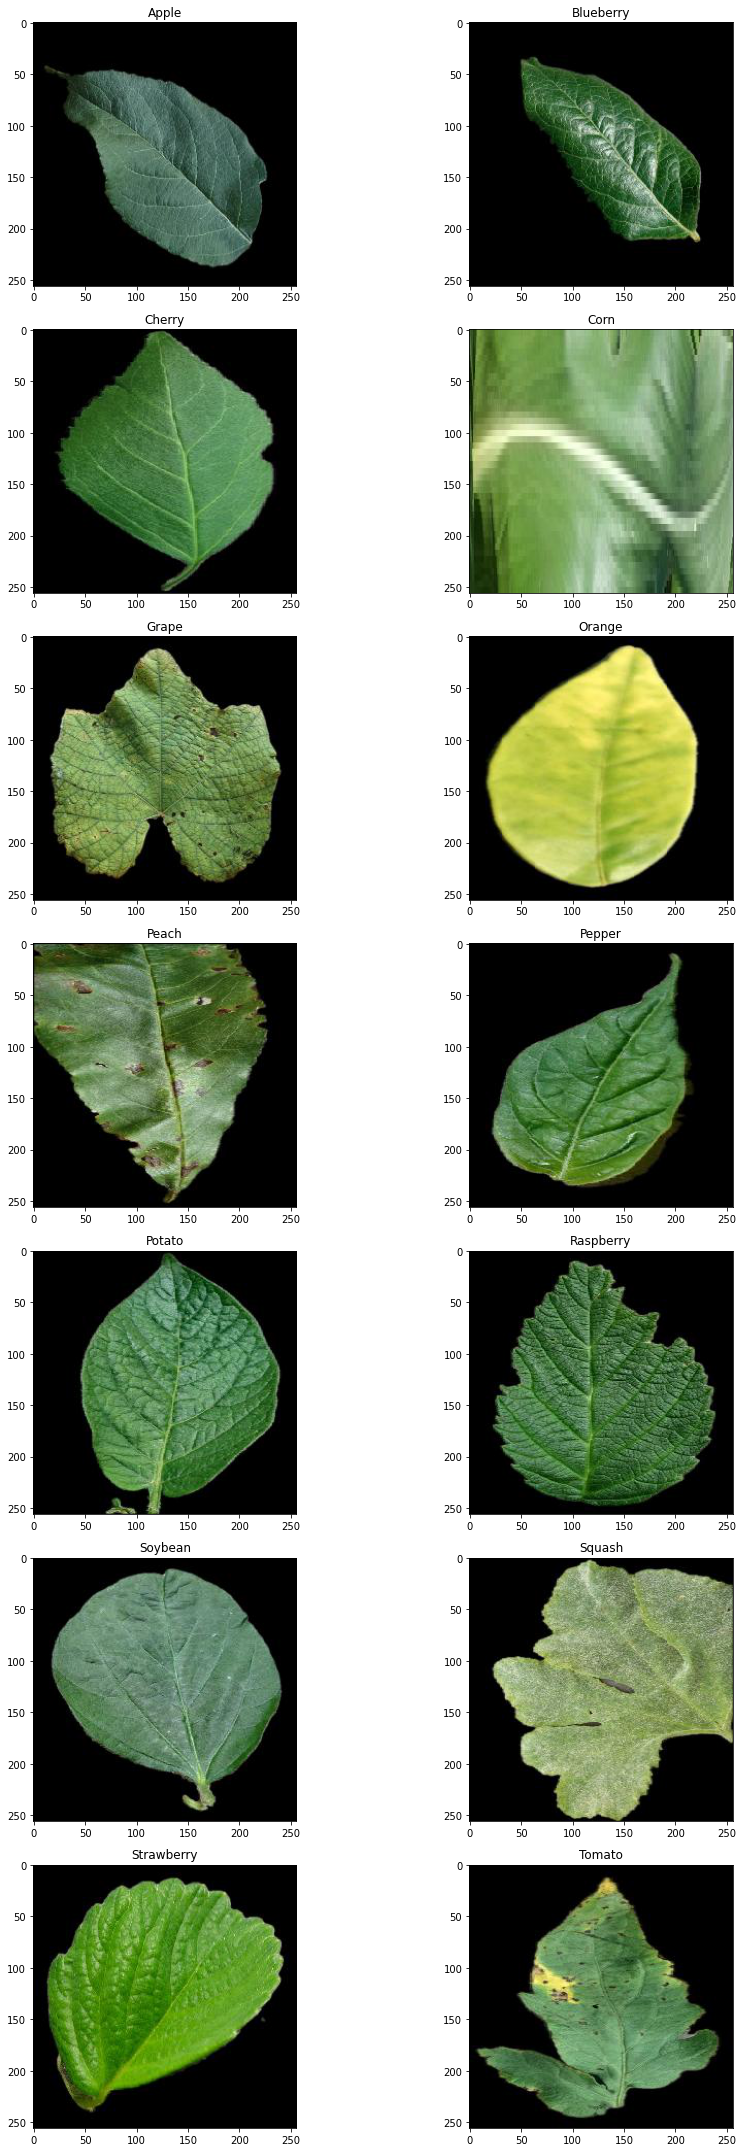

In [ ]:
# Plot example images from dataset
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
batch_size = 128

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#2 data generator since we aug ONLY the training set 

train_data_gen = ImageDataGenerator(rotation_range=30,
                                    height_shift_range=50,
                                    width_shift_range=50,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True, 
                                    fill_mode='constant', cval=0, # IN CLASS fill_mode='reflect'
                                    validation_split=0.2)

valid_data_gen = ImageDataGenerator(validation_split=0.2) 


aug_train_gen = train_data_gen.flow_from_directory(directory=dataset_dir,
                                         target_size=(256,256),
                                         color_mode='rgb',
                                         classes=None,
                                         class_mode='categorical',
                                         batch_size=batch_size,
                                         shuffle=True,
                                         seed=seed,
                                         subset='training')

valid_gen = valid_data_gen.flow_from_directory(directory=dataset_dir,
                                         target_size=(256, 256),
                                         color_mode='rgb',
                                         classes=None,
                                         class_mode='categorical',
                                         batch_size=batch_size,
                                         shuffle=True,
                                         seed=seed,
                                         subset='validation')

Found 14189 images belonging to 14 classes.
Found 3539 images belonging to 14 classes.


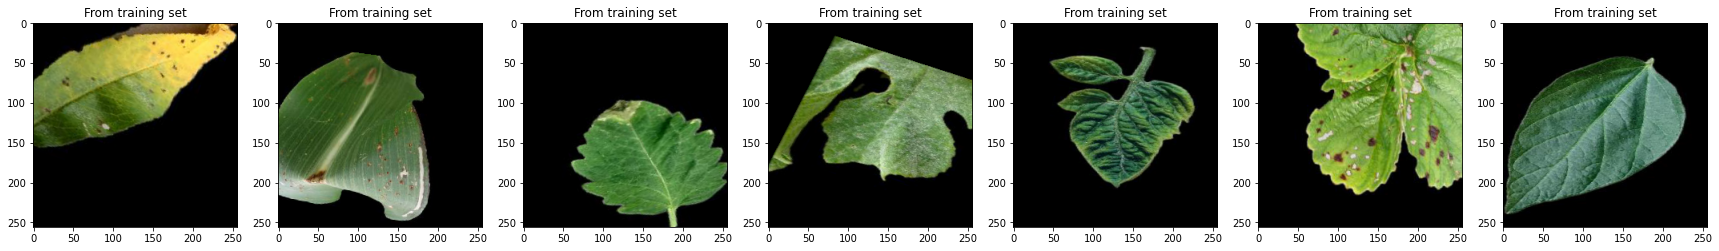

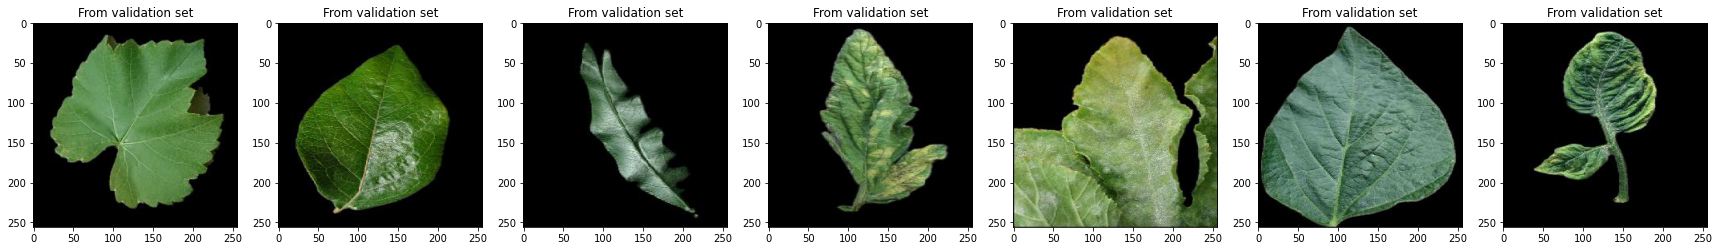

In [ ]:
#explore training set and validation set
#only the images from training set should appear augmented 

train_batch = next(aug_train_gen)
valid_batch = next(valid_gen)

fig, ax = plt.subplots(1, 7, figsize=(30,45))
for i in range(0,7):
  ax[i].imshow(np.uint8(train_batch[0][i]))
  ax[i].set_title("From training set")

fig, ax = plt.subplots(1, 7, figsize=(30,45))
for i in range(0,7):
  ax[i].imshow(np.uint8(valid_batch[0][i]))
  ax[i].set_title("From validation set")

In [ ]:
# Check class labels in the data

print("Assigned labels")
print(aug_train_gen.class_indices)
print()
print("Target classes")
print(aug_train_gen.classes)

Assigned labels
{'Apple': 0, 'Blueberry': 1, 'Cherry': 2, 'Corn': 3, 'Grape': 4, 'Orange': 5, 'Peach': 6, 'Pepper': 7, 'Potato': 8, 'Raspberry': 9, 'Soybean': 10, 'Squash': 11, 'Strawberry': 12, 'Tomato': 13}

Target classes
[ 0  0  0 ... 13 13 13]


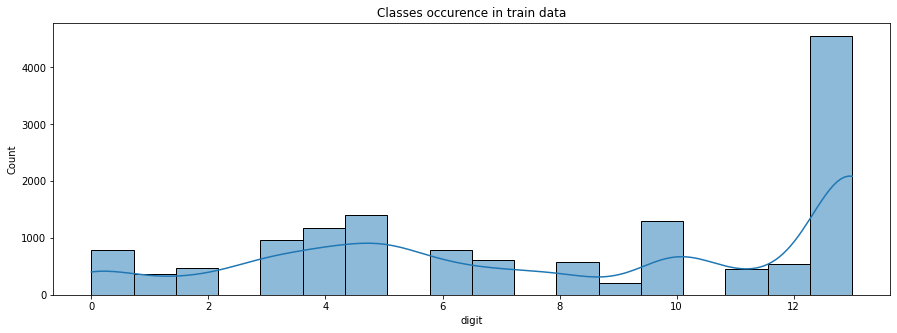

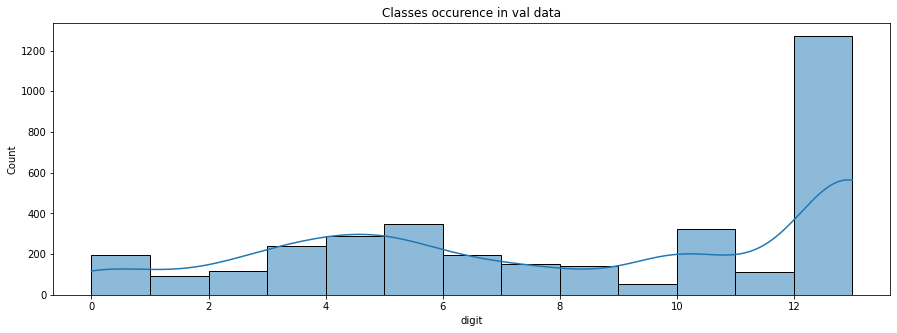

In [ ]:
# Data exploration: check class distribution in training and validation data
plt.figure(figsize=(15,5))
sns.histplot(data=pd.DataFrame(aug_train_gen.classes, columns=['digit']), x='digit', kde=True)
plt.title("Classes occurence in train data")
plt.show()

plt.figure(figsize=(15,5))
sns.histplot(data=pd.DataFrame(valid_gen.classes, columns=['digit']), x='digit', kde=True)
plt.title("Classes occurence in val data")
plt.show()

#Obs: class distribution is more or less preserved in train and val data

In [ ]:
# Models metadata
input_shape = (256, 256, 3)
epochs = 200

# Fine-Tuning

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('Experiment results/BEST_vgg16_data_aug')
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 14)                3598      
                                                             

In [ ]:
# Set all VGG layers to True
ft_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
# Freeze first 15 layers
for i, layer in enumerate(ft_model.get_layer('vgg16').layers[:15]):
  layer.trainable=False

for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                               

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

In [ ]:
# Considering class imbalance: class weightning
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(aug_train_gen.classes),
                                        y = aug_train_gen.classes                                                   
                                    )
class_weights = dict(zip(np.unique(aug_train_gen.classes), class_weights))
class_weights

{0: 1.2812895069532237,
 1: 2.7098930481283423,
 2: 2.170235546038544,
 3: 1.050259067357513,
 4: 0.8684661525278492,
 5: 0.724446032880629,
 6: 1.2960358056265984,
 7: 1.6560457516339868,
 8: 1.768760907504363,
 9: 4.78066037735849,
 10: 0.7838360402165506,
 11: 2.2032608695652174,
 12: 1.8803339517625233,
 13: 0.2225027442371021}

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('Experiment results')

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp'),
                                                     save_weights_only=False,
                                                     save_best_only=False)
  callbacks.append(ckpt_callback)

  # Early Stopping
  # --------------
  es_callback = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [ ]:
# Create folders and callbacks and fit
callbacks = create_folders_and_callbacks(model_name='VGG16_aug_finetuned')

# Train model with classes weighted to overcame class imbalance problems
history = ft_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = callbacks,
    class_weight = class_weights #added class weights here
).history

Epoch 1/200
111/111 [==============================] - 3066s 27s/step - loss: 0.2285 - accuracy: 0.9279 - val_loss: 0.1299 - val_accuracy: 0.9587
Epoch 2/200
111/111 [==============================] - 282s 3s/step - loss: 0.1053 - accuracy: 0.9586 - val_loss: 0.3938 - val_accuracy: 0.9028
Epoch 3/200
111/111 [==============================] - 276s 2s/step - loss: 0.0854 - accuracy: 0.9637 - val_loss: 0.1127 - val_accuracy: 0.9692
Epoch 4/200
111/111 [==============================] - 278s 3s/step - loss: 0.0832 - accuracy: 0.9681 - val_loss: 0.3956 - val_accuracy: 0.9141
Epoch 5/200
111/111 [==============================] - 283s 3s/step - loss: 0.0570 - accuracy: 0.9736 - val_loss: 0.2141 - val_accuracy: 0.9460
Epoch 6/200
111/111 [==============================] - 283s 3s/step - loss: 0.0535 - accuracy: 0.9781 - val_loss: 0.0528 - val_accuracy: 0.9842
Epoch 7/200
111/111 [==============================] - 290s 3s/step - loss: 0.0572 - accuracy: 0.9755 - val_loss: 0.1909 - val_accurac

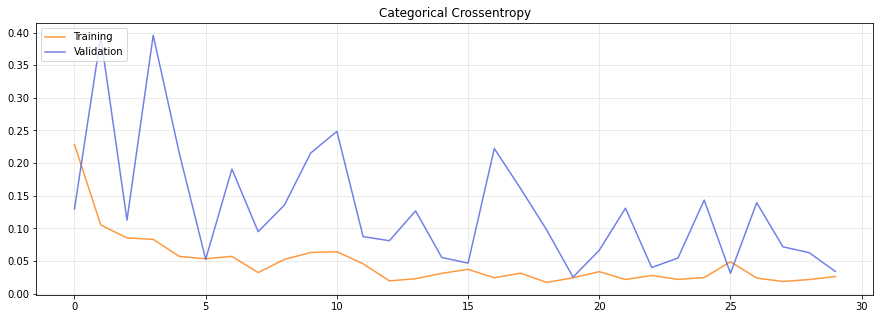

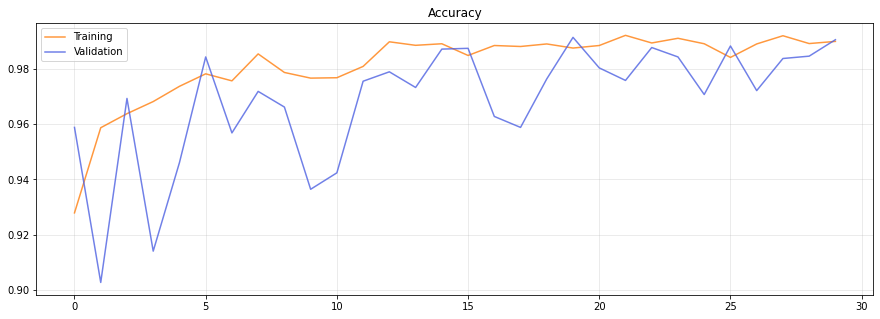

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# this model seems a good starting point :). Let's save it!
ft_model.save("Experiment results/VGG16_aug_finetuned")

INFO:tensorflow:Assets written to: Experiment results/VGG16_aug_finetuned/assets
